# Hyperlinks' clickability preferences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse

In [2]:
import os, sys

# HTLM files URLs in a list 
wp_path = "/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/" # to adapt
directories = os.listdir(wp_path)
html_list = []
for dir in directories:
    local_path = wp_path + dir
    local_dir = os.listdir(local_path)
    for link in local_dir:
        if link[-3:]=='htm':
            html_list.append(dir+'/'+link)
html_list[:10]

['r/Royal_Marines.htm',
 'r/Recycling.htm',
 'r/Retreat_of_glaciers_since_1850.htm',
 'r/Remember_Girls_Like_Rajpura.htm',
 'r/Rutherfordium.htm',
 'r/Rule_of_St_Benedict.htm',
 'r/Red_dwarf.htm',
 'r/Romeo_and_Juliet.htm',
 'r/Rudyard_Kipling.htm',
 'r/Race.htm']

## Objective

The aim of this specific section of our game strategy analysis is to test whether Wikispeedia players have clikability preferences on the basis of the hyperlinks' positioning throughout the article text. 
In particular:
1. we wil find the ordinal number of the paragraph each hyperlink in an article shows up in and divide it by the total number of paragraphs of the article, to determine its positioning; 
2. we will determine if each hyperlink in an article shows up in an image caption.

We will then investigate if there is a correlation between the clickability of the hyperlinks and their location, using the proper statistical tests. 

### Hyperlinks positioning in articles' text

It is essential to extract from the data the frequency of clicks for each hyperlink.

In [3]:
# read files 
folder='/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wikispeedia_paths-and-graph/'

paths_finished='paths_finished.tsv'
paths_unfinished='paths_unfinished.tsv'
articles='articles.tsv'

paths_finished=pd.read_csv(folder+paths_finished, sep='\t', skiprows=15, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished=pd.read_csv(folder+paths_unfinished, sep='\t', skiprows=16, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
articles=pd.read_csv(folder+articles, sep='\t', skiprows=12, header=None, names=['article'])

The dataframe `paths_finished` contains the paths chosen by the players who could reach the target article.

In [4]:
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


The dataframe `paths_unfinished` contains the paths chosen by the players who could not reach the target article.

In [5]:
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


The dataframe `articles` lists all the clickable articles/links.

In [6]:
# encode and filter link names
def filter_link_list(links_list):
    new_links_list=[]
    for link in links_list:
        link=urllib.parse.unquote(link)
        link=link.lower()
        link=link.replace('_', ' ')
        link=link.strip()
        new_links_list.append(link)
    return new_links_list

articles.article=filter_link_list(articles.article)
articles.head(10)

,article
0,áedán mac gabráin
1,åland
2,édouard manet
3,éire
4,óengus i of the picts
5,€2 commemorative coins
6,10th century
7,11th century
8,12th century
9,13th century


In [7]:
print('The total number of articles comprising the Wikispeedia library is {0}.'.format(len(articles)))

The total number of articles comprising the Wikispeedia library is 4604.


The dataframe `clicked_links_filtered` contains the clicked links troughout the paths.

In [8]:
clicked_links=[]
for x in paths_finished['path']: 
    path=(x.split(';')) # get list of links along the path string 
    clicked_links.append(path)

clicked_links_filtered=[] # consistent with other dfs
for path in clicked_links:
    path_filtered=filter_link_list(path)
    if '<' in path: 
        path.remove('<') # remove backclicks
    clicked_links_filtered.append(path_filtered)

clicked_links_filtered[:5]

[['14th century',
  '15th century',
  '16th century',
  'pacific ocean',
  'atlantic ocean',
  'accra',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'europe',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'niger',
  'nigeria',
  'british empire',
  'slavery',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century', 'renaissance', 'ancient greece', 'greece'],
 ['14th century',
  'italy',
  'roman catholic church',
  'hiv',
  'ronald reagan',
  'president of the united states',
  'john f. kennedy']]

The dataframe `links_freq_df` contains the links' frequency of clicks.

In [9]:
links_name=[]
links_freq=[]

i=0
for article in articles['article']: # count the number of times each article shows up in paths
    count=0
    links_name.append(article)
    for i in range(len(clicked_links_filtered)):
        if article in clicked_links_filtered[i]:
            count+=1 
    links_freq.append(count)

links_name=pd.Series(links_name)
links_freq=pd.Series(links_freq)
links_freq_df=pd.concat([links_name, links_freq], axis=1, names=['link', '#_clicks'])
links_freq_df.columns=['link', '#_clicks']
links_freq_df.loc[links_freq_df['#_clicks']!=0].head()

,link,#_clicks
1,åland,2
2,édouard manet,2
3,éire,3
5,€2 commemorative coins,1
6,10th century,109


In [10]:
clicks_tot=links_freq_df['#_clicks'].sum()
print('The total number of clicked hyperlinks is {0}.'.format(clicks_tot))

The total number of clicked hyperlinks is 321717.


Next step of the descriptive analysis process is the html files parsing aimed at determining the location of hyperlinks. 

In [11]:
# parse html files 

from bs4 import BeautifulSoup

soups=[]
failed_html_list = []
for html in html_list[:]:
    f=open(wp_path+html, 'r')
    try:
        soup = BeautifulSoup(f, 'lxml')
        soups.append(soup)
    except Exception:
        failed_html_list.append(html)

In [12]:
print('{0} files were not parsable. However, they are not reachable nor it is possible to click \
any hyperlink in those html pages.'.format(len(failed_html_list)))

53 files were not parsable. However, they are not reachable nor it is possible to click any hyperlink in those html pages.


`link_positioning_dfs` is a list of dataframes (`link_positioning_df`) containing hyperlinks showing up in one html file, the ordinal number of the paragraph they belong to and their relative positioning throughout the article text. 

In [13]:
# HTML tag for hyperlinks is <a href= >
# the function finds all <a href= > tags throughout the article html file

def find_links(soup): 
    paragraphs = soup.find_all('p') 
    links=[]
    i=0
    for p in paragraphs:
        i+=1
        all_links=p.find_all('a')
        for link in all_links:
            if 'href' in link.attrs:
                link_title=link.text
                link_paragraph=i
                links.append([link_title, link_paragraph])
                
    link_positioning_df=pd.DataFrame(links, columns=['link', '#_paragraph']).drop_duplicates()
    link_positioning_df['positioning']=round(link_positioning_df['#_paragraph']/len(paragraphs), 2)
    link_positioning_df['link']=filter_link_list(link_positioning_df['link'])
    return link_positioning_df

In [14]:
# apply the function to all html files

link_positioning_dfs=[]
for soup in soups:
    link_positioning_dfs.append(find_links(soup))

link_positioning_dfs[:5]

[                              link  #_paragraph  positioning
 0                       royal navy            1         0.01
 1                   united kingdom            1         0.01
 2                         cold war           18         0.19
 3                     sierra leone           20         0.21
 4                         dartmoor           24         0.25
 5                     world war ii           29         0.30
 6                         plymouth           34         0.35
 7                         scotland           34         0.35
 8                        gibraltar           43         0.44
 9                             cuba           44         0.45
 10               george washington           44         0.45
 11                      royal navy           45         0.46
 13                      portsmouth           46         0.47
 14                        plymouth           46         0.47
 15      american revolutionary war           46         0.47
 16     

In [15]:
print('{0} html files were parsed.'.format(len(link_positioning_dfs)))

5409 html files were parsed.


In [16]:
# example with 2 files

URL_1 = wp_path+'a/A_cappella.htm'
URL_2 = wp_path+'m/Music.htm'

f1=open(URL_1, 'r')
soup1 = BeautifulSoup(f1, 'lxml')

f2=open(URL_2, 'r')
soup2 = BeautifulSoup(f2, 'lxml')

link_positioning_df_1=find_links(soup1).drop(labels='#_paragraph', axis=1)
link_positioning_df_2=find_links(soup2).drop(labels='#_paragraph', axis=1)

# merging the 2 dataframes 

merged_dfs=link_positioning_df_1.merge(link_positioning_df_2, how='outer', left_on='link', right_on='link', )
merged_dfs

,link,positioning_x,positioning_y
0,music,0.04,NaN
1,instrumental,0.04,NaN
2,renaissance,0.04,NaN
3,renaissance,0.12,NaN
4,gregorian chant,0.12,NaN
5,amish,0.21,NaN
6,eastern orthodox,0.21,NaN
7,jewish,0.33,NaN
8,beatles,0.75,NaN
9,hindi,0.88,NaN


The hyperlink _rap_ shows up in both articles; the hyperlink _jazz_, _renaissance_ and _time_ show up multiple times in one article. 

The two occurrences highlighted are likely to be the case for every hyperlink, when all dataframes will be merged. It is therefore essential to compute their most likely positioning in the articles' texts, so to extract any meaningful information from the data.  

In [17]:
# merge all the link_positioning_df in link_positioning_dfs list on hyperlink in order to apply a function 
# that determines the most frequent positioning of the hyperlinks


link_positioning_dfs_grouped=[]

fail=0  
for i, df in enumerate(link_positioning_dfs):
    try:
        df=df.set_index("link")
        df=df["positioning"].groupby("link").apply(lambda x: x.values).rename(f"article_{i}")
        link_positioning_dfs_grouped.append(df)
    except:
        fail+=1
        pass 

from itertools import chain
link_positioning_concatenated=(pd.concat(link_positioning_dfs_grouped)
                               .groupby("link")
                               .apply(lambda x: list(chain(*x.values))))
link_positioning_concatenated[:10]

link
                                [0.78, 0.8, 0.84, 0.85, 0.87, 0.89, 0.91, 0.93...
"6 villages for 2006                                                       [0.67]
"6 villages for 2006"                                                [0.36, 0.46]
"capitalist rule"                                                          [0.16]
"consumption" (tuberculosis)                                               [0.03]
"glorious revolution"                                                      [0.39]
"grave"                                                                    [0.31]
"law of queen anne"                                                        [0.52]
"name and anagram"                                                          [0.1]
"nostalgic tram" no. 91                                                    [0.76]
dtype: object

In [18]:
# function that determines the most frequent positioning of each hyperlink in the set of all links

def find_positioning(array):
    bin_labels=['top', 'center-top','center','center-bottom', 'bottom'] # positioning is classified as top, centre-top, center, center-bottom, or bottom of the article
    bins=[0, 0.20, 0.40, 0.60, 0.80, 1] 
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning) # frequency of the bins
    most=positioning_frequency.apply('max') # bin with highest frequency
    if len(positioning_frequency[positioning_frequency==most])>1:
        return np.random.choice(positioning_frequency[positioning_frequency==most].index.values.astype(str)) #account for same frequency
    else:
        return positioning_frequency[positioning_frequency==most].index.values.astype(str).item()

The dataframe `most_freq_positioning_df` contains the hyperlinks' most frequent positioning.

In [19]:
# all html files

most_freq_positioning=link_positioning_concatenated.apply(find_positioning)
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])
most_freq_positioning_df.reset_index()

,link,most_freq_positioning
0,,bottom
1,"""6 villages for 2006",center-bottom
2,"""6 villages for 2006""",center-top
3,"""capitalist rule""",top
4,"""consumption"" (tuberculosis)",top
...,...,...
10528,‘6 villages for 2006’,center-bottom
10529,“6 villages for 2006”,center
10530,€,center-bottom
10531,€25 million,top


The dataframe `links_freq_pos` contains both the hyperlinks' most frequent positioning and their frequency of clicks.

In [20]:
links_freq_pos=links_freq_df.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,top
1,åland,2.0,bottom
2,édouard manet,2.0,center-bottom
3,éire,3.0,top
4,óengus i of the picts,0.0,NaN
...,...,...,...
11515,‘6 villages for 2006’,NaN,center-bottom
11516,“6 villages for 2006”,NaN,center
11517,€,NaN,center-bottom
11518,€25 million,NaN,top


In [21]:
not_clicked=links_freq_pos['#_clicks'].isnull().value_counts()[0]
print('There are {0} links in the articles, {1} never clicked.'.format(len(most_freq_positioning_df), not_clicked))

There are 10533 links in the articles, 4604 never clicked.


The dataframe `links_freq_pos_grouped_df` groups the hyperlinks click frequency by their positioning.

In [22]:
links_freq_pos_grouped=links_freq_pos['#_clicks'].groupby(links_freq_pos['most_freq_positioning']).sum()
links_freq_pos_grouped_df=pd.DataFrame(links_freq_pos_grouped)
links_freq_pos_grouped_df['#_clicks_norm']=links_freq_pos_grouped_df['#_clicks']/clicks_tot #normalization
links_freq_pos_grouped_df

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,31778.0,0.098776
center,17107.0,0.053174
center-bottom,19455.0,0.060472
center-top,26570.0,0.082588
top,216406.0,0.672660


In order to compare the hyperlinks click frequencies with regard to their positioning (i.e. _top_, _center-top_, _center_, _center-bottom_, _bottom_) their absolute values need to be normalized with the bins' frequencies (i.e. the number of times the hypelinks actually show up in the categorical positioning).

The dataframe `positioning_freq_df_grouped` contains the frequency of hyperlinks showing up in the Wikispeedia set of articles grouped by their positioning throughout the text. 

In [23]:
# function that counts the frequency of a link showing up at the top, center, bottom of the article

def find_positioning_dis(array):
    bin_labels=['top', 'center-top','center', 'center-bottom', 'bottom']
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning)
    return positioning_frequency

In [24]:
# apply the function to the dataframe links positioning grouped by link  

positioning_freq=link_positioning_concatenated.apply(find_positioning_dis)
positioning_freq

,bottom,top,center-bottom,center,center-top
link,,,,,
,220,130,45,42,33
"""6 villages for 2006",0,0,1,0,0
"""6 villages for 2006""",0,0,0,1,1
"""capitalist rule""",0,1,0,0,0
"""consumption"" (tuberculosis)",0,1,0,0,0
...,...,...,...,...,...
‘6 villages for 2006’,0,0,1,0,1
“6 villages for 2006”,0,0,0,1,0
€,2,2,6,3,4


In [25]:
positioning_freq_grouped=positioning_freq.sum(axis=0) # group by positioning
positioning_freq_grouped_df=pd.DataFrame(positioning_freq_grouped, columns=['nr'])
links_tot=positioning_freq_grouped_df['nr'].sum()
positioning_freq_grouped_df['nr_norm']=positioning_freq_grouped_df['nr']/links_tot
positioning_freq_grouped_df

,nr,nr_norm
bottom,24193,0.184871
top,40824,0.311957
center-bottom,22588,0.172607
center,20228,0.154573
center-top,23031,0.175992


In [26]:
vis=links_freq_pos_grouped_df.merge(positioning_freq_grouped_df, left_index=True, right_index=True)
vis

,#_clicks,#_clicks_norm,nr,nr_norm
bottom,31778.0,0.098776,24193,0.184871
center,17107.0,0.053174,20228,0.154573
center-bottom,19455.0,0.060472,22588,0.172607
center-top,26570.0,0.082588,23031,0.175992
top,216406.0,0.672660,40824,0.311957


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '#_clicks / #_hyperlinks')

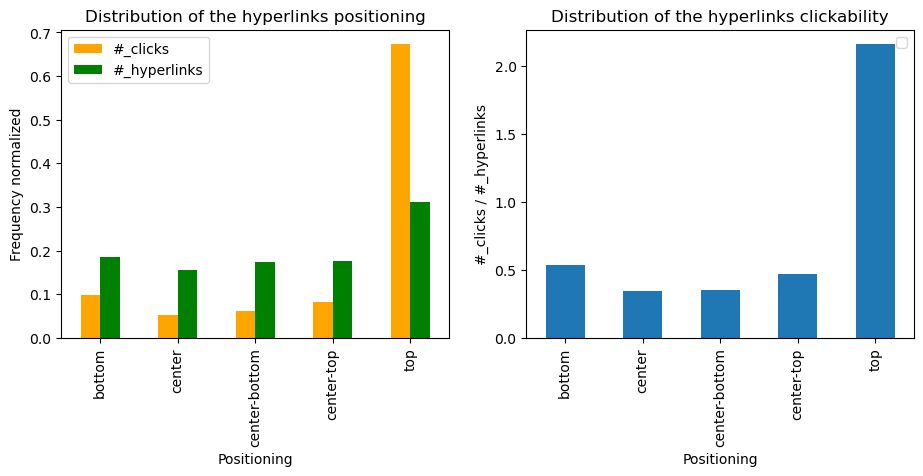

In [27]:
# visualization of the distribution of the clicked hyperlinks' positioning

# dataframe for visualization
vis=links_freq_pos_grouped_df.merge(positioning_freq_grouped_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1,2, figsize=(11,4))
vis.plot(y=['#_clicks_norm', 'nr_norm'], kind='bar', ax=ax[0], label=['#_clicks', '#_hyperlinks'], color=['orange', 'green'])
ax[0].legend()
ax[0].set_title('Distribution of the hyperlinks positioning')
ax[0].set_xlabel('Positioning')
ax[0].set_ylabel('Frequency normalized')

vis['clicked']=vis['#_clicks_norm']/vis['nr_norm'] # not sure
vis.plot(y='clicked', kind='bar', ax=ax[1], label='')
ax[1].legend()
ax[1].set_title('Distribution of the hyperlinks clickability')
ax[1].set_xlabel('Positioning')
ax[1].set_ylabel('#_clicks / #_hyperlinks')

The bar plot on the left illustrates the distribution of the clicked hyperlinks and the total number of links in the articles, on the basis of their positioning throughout the articles text, both normalized. 

The bar plot on the right illustrates the hyperlinks clickability on the basis of their positioning. More precisely: 
1. a value of 1 (_\#_clicks_/_\#_hyperlinks_ = 1) corresponds to a hyperlinks clickability on average equally proportional to the normalized frequency of the specific categorical positioning (i.e. the number of clicks proportional to the number times a hyperlink shows up in a section of the article);
2. a value of greater than 1, points a more than proportional clickability;
3. a value of smaller than 1, points a less than proportional clickability.

### Hyperlinks positioning in images' caption

The following part of the descriptive analysis focuses on the location of hyperlinks in images' captions.

Images in html files can be either found under \<div> or \<table> tag, while the hyperlinks are found in their captions under \<div class='thumbcaption'> tag.

The dataframe `links_in_tables` contains the links showing up in tables' captions. 

In [28]:
# parse html file and search hyperlinks in the captions of tables containing images 

def find_link_in_table(soup):
    
    tables = soup.find_all('table')

    links=[]
    for table in tables:
        if table.find('img'):
            all_links=table.find_all('a')
            for link in all_links:
                if 'class' not in link.attrs:
                    link_title=link.text
                    links.append(link_title)

    if links:
        links_in_table_df=pd.DataFrame(links).drop_duplicates()
        links_in_table_df.columns=['link']
        links_in_table_df=links_in_table_df.apply(filter_link_list) 
    else: 
        return None
    return links_in_table_df

In [29]:
links_in_tables=[]
for soup in soups:
    links_in_tables.append(find_link_in_table(soup))

links_in_tables_df=pd.concat(links_in_tables, axis=0)
links_in_tables_df.head()

,link
0,royal navy
1,united kingdom
3,plymouth
4,latin
0,lawrencium


In [30]:
links_in_tables_tot=len(links_in_tables_df)
print('The total number of links in tables captions is {0}.'.format(links_in_tables_tot))

The total number of links in tables captions is 15159.


The dataframe `links_in_images` contains the links showing up in images' captions.

In [31]:
# parse html file and search hyperlinks in the captions of div containing images 

def find_links_in_img(soup):
    div = soup.find_all('div')

    links=[]

    for d in div:
        if (d.find('a', class_="internal")):
            if (d.find('img', class_='thumbimage')):
                caption=d.find('div', class_="thumbcaption")
                if (caption.find('a')):
                    all_links=caption.find_all('a')
                    for link in all_links:
                        if 'class' not in link.attrs:
                            link_title=link.text
                            links.append(link_title)
    if links:
        links_in_image_df=pd.DataFrame(links).drop_duplicates()
        links_in_image_df.columns=['link']
        links_in_image_df=links_in_image_df.apply(filter_link_list) 
    else: 
        return None
        links_in_image_df=pd.DataFrame()
    return links_in_image_df

In [32]:
links_in_images=[]
for soup in soups:
    links_in_images.append(find_links_in_img(soup))


links_in_images_df=pd.concat(links_in_images, axis=0)
links_in_images_df.head()

,link
0,bangladesh
0,portsmouth
2,england
4,india
0,pompeii


In [33]:
links_in_images_tot=len(links_in_images_df)
print('The total number of links in images captions is {0}.'.format(links_in_images_tot))

The total number of links in images captions is 372.


Next, the supposed clickability preference for a hyperlink showing up in an image will be investigated, by grouping the click frequency by hyperlinks' location.

In [34]:
# drop indexes to ease the flagging
links_in_images_df=links_in_images_df.reset_index(drop=True)
links_in_tables_df=links_in_tables_df.reset_index(drop=True)

In [35]:
links_freq_df

,link,#_clicks
0,áedán mac gabráin,0
1,åland,2
2,édouard manet,2
3,éire,3
4,óengus i of the picts,0
...,...,...
4599,zionism,19
4600,zirconium,30
4601,zoroaster,13
4602,zuid-gelders,8


The dataframe `links_freq_img` contains hyperlinks click frequency and a flag specifying if they can be found in images' captions.

In [36]:
# link in image

flag_img=[]
links_freq_img=links_freq_df.copy()

for link in links_freq_img['link']:
    if link in list(links_in_images_df['link']):
        flag_img.append(1)
    else:
        flag_img.append(0)
    
links_freq_img['in_image']=flag_img
links_freq_img[links_freq_img['in_image']==1][:10]

,link,#_clicks,in_image
1,åland,2,1
2,édouard manet,2,1
7,11th century,115,1
15,16th century,219,1
19,18th century,236,1
38,20th century,736,1
145,agamemnon,26,1
151,airbus a380,50,1
156,akbar,8,1
172,albrecht dürer,13,1


The dataframe `links_freq_tab` contains hyperlinks click frequency and a flag specifying if they can be found in tables' captions.

In [37]:
# link in table

flag_tab=[]
links_freq_tab=links_freq_df.copy()

for link in links_freq_tab['link']:
    if link in list(links_in_tables_df['link']):
        flag_tab.append(1)
    else:
        flag_tab.append(0)
    
links_freq_tab['in_tab']=flag_tab
links_freq_tab[links_freq_tab['in_tab']==1][:10]

,link,#_clicks,in_tab
1,åland,2,1
2,édouard manet,2,1
9,13th century,128,1
12,15th century,186,1
15,16th century,219,1
19,18th century,236,1
24,19th century,513,1
30,2003 atlantic hurricane season,29,1
31,2004 atlantic hurricane season,44,1
33,2005 atlantic hurricane season,115,1


In [38]:
# find normalized values of clicks (#_clicks) on the basis of the relative number of times a hyperlink shows up in an 
# image caption to occurrence in the article text 

# images 

links_in_img=pd.concat(links_in_images, axis=0).reset_index(drop=True)

link_in_img_freq=[]
link_name=[]

for link in list(links_in_img['link']):
    count=list(links_in_img['link']).count(link)
    link_name.append(link)
    link_in_img_freq.append(count)

link_name=pd.Series(link_name)
link_in_img_freq=pd.Series(link_in_img_freq)
link_in_img_freq_df=pd.concat([link_name, link_in_img_freq], axis=1)
link_in_img_freq_df.columns=['link', '#_link_in_img']
link_in_img_freq_df

,link,#_link_in_img
0,bangladesh,1
1,portsmouth,1
2,england,4
3,india,4
4,pompeii,1
...,...,...
367,germany,1
368,albrecht dürer,2
369,sculptures,1
370,europe,1


In [39]:
# links showing up in images' captions and also in texts

links_in_text=pd.concat(link_positioning_dfs, axis=0)['link']
link_in_text_freq=[]
link_name=[]

for link in list(links_in_img['link']):
    count=list(links_in_text).count(link)
    link_name.append(link)
    link_in_text_freq.append(count)

link_name_text=pd.Series(link_name)
link_in_text_freq=pd.Series(link_in_text_freq)
link_in_text_freq_df=pd.concat([link_name_text, link_in_text_freq], axis=1)
link_in_text_freq_df.columns=['link', '#_link_in_text']
link_in_text_freq_df

,link,#_link_in_text
0,bangladesh,100
1,portsmouth,25
2,england,635
3,india,667
4,pompeii,19
...,...,...
367,germany,634
368,albrecht dürer,14
369,sculptures,4
370,europe,780


In [40]:
df_img=pd.merge(links_freq_img[links_freq_img['in_image']==1], link_in_img_freq_df, left_on='link', right_on='link')
new_df_img=pd.merge(df_img, link_in_text_freq_df, left_on='link', right_on='link')
new_df_img=new_df_img.set_index('link')
new_df_img

,#_clicks,in_image,#_link_in_img,#_link_in_text
link,,,,
åland,2,1,1,4
édouard manet,2,1,1,10
11th century,115,1,1,29
16th century,219,1,1,85
18th century,236,1,1,125
...,...,...,...,...
william hogarth,15,1,2,8
william hogarth,15,1,2,8
william hogarth,15,1,2,8


In [41]:
norm_values_img=new_df_img['#_link_in_img']/new_df_img['#_link_in_text']
clicks_norm_img=(new_df_img['#_clicks']*norm_values_img)
clicks_norm_img.replace([np.inf, -np.inf], np.nan, inplace=True)
clicks_norm_img=clicks_norm_img.fillna(0).values.astype('int')

In [42]:
links_freq_img=links_freq_img.set_index('link')
links_freq_img.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_img.loc[norm_values_img.index,'#_clicks_norm']=clicks_norm_img
links_freq_img

,#_clicks_norm,in_image
link,,
áedán mac gabráin,0,0
åland,0,1
édouard manet,0,1
éire,3,0
óengus i of the picts,0,0
...,...,...
zionism,19,0
zirconium,30,0
zoroaster,13,0


In [43]:
# tables 

links_in_tab=pd.concat(links_in_tables, axis=0).reset_index(drop=True)

link_in_tab_freq=[]
link_name=[]

for link in list(links_in_tab['link']):
    count=list(links_in_tab['link']).count(link)
    link_name.append(link)
    link_in_tab_freq.append(count)

link_name=pd.Series(link_name)
link_in_tab_freq=pd.Series(link_in_tab_freq)
link_in_tab_freq_df=pd.concat([link_name, link_in_tab_freq], axis=1)
link_in_tab_freq_df.columns=['link', '#_link_in_tab']

In [44]:
links_in_text=pd.concat(link_positioning_dfs, axis=0)['link']
link_in_text_freq=[]
link_name=[]

for link in list(links_in_tab['link']):
    count=list(links_in_text).count(link)
    link_name.append(link)
    link_in_text_freq.append(count)

link_name_text=pd.Series(link_name)
link_in_text_freq=pd.Series(link_in_text_freq)
link_in_text_freq_df=pd.concat([link_name_text, link_in_text_freq], axis=1)
link_in_text_freq_df.columns=['link', '#_link_in_text']

In [45]:
df_tab=pd.merge(links_freq_tab[links_freq_tab['in_tab']==1], link_in_tab_freq_df, left_on='link', right_on='link')
new_df_tab=pd.merge(df_tab, link_in_text_freq_df, left_on='link', right_on='link')
new_df_tab=new_df_tab.set_index('link')

norm_values_tab=new_df_tab['#_link_in_tab']/new_df_tab['#_link_in_text']
clicks_norm_tab=(new_df_tab['#_clicks']*norm_values_tab)
clicks_norm_tab.replace([np.inf, -np.inf], np.nan, inplace=True)
clicks_norm_tab=clicks_norm_tab.fillna(0).values.astype('int')

links_freq_tab=links_freq_tab.set_index('link')
links_freq_tab.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_tab.loc[norm_values_tab.index,'#_clicks_norm']=clicks_norm_tab
links_freq_tab

,#_clicks_norm,in_tab
link,,
áedán mac gabráin,0,0
åland,0,1
édouard manet,0,1
éire,3,0
óengus i of the picts,0,0
...,...,...
zionism,1,1
zirconium,5,1
zoroaster,13,0


The dataframe `links_freq_img_grouped_df` contains the frequency of clicks for hyperlinks showing up in images' captions and not, and their normalized values.

In [46]:
links_freq_img_grouped_df=pd.DataFrame(links_freq_img['#_clicks_norm'].groupby(links_freq_img['in_image']).sum())

links_freq_img_grouped_df.loc[0,'#_clicks/#_links_img']=links_freq_img_grouped_df.loc[0,'#_clicks_norm']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df.loc[1,'#_clicks/#_links_img']=links_freq_img_grouped_df.loc[1,'#_clicks_norm']/links_in_images_tot

links_freq_img_grouped_df

,#_clicks_norm,#_clicks/#_links_img
in_image,,
0,264953,2.030416
1,752,2.021505


The dataframe `links_freq_tab_grouped_df` contains the frequency of clicks for hyperlinks showing up in tables' captions and not, and their normalized values.

In [47]:
links_freq_tab_grouped_df=pd.DataFrame(links_freq_tab['#_clicks_norm'].groupby(links_freq_tab['in_tab']).sum())

links_freq_tab_grouped_df.loc[0,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[0,'#_clicks_norm']/(links_tot-links_in_tables_tot)
links_freq_tab_grouped_df.loc[1,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[1,'#_clicks_norm']/links_in_tables_tot

links_freq_tab_grouped_df

,#_clicks_norm,#_clicks/#_links_tab
in_tab,,
0,135920,1.174712
1,93817,6.188865


Text(0.5, 1.0, 'Clicability of hyperlinks in captions')

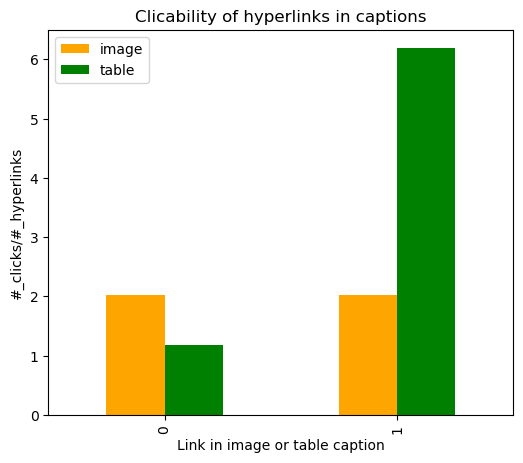

In [48]:
# dataframe for visualization
vis_img=links_freq_img_grouped_df.merge(links_freq_tab_grouped_df, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(6,5))
vis_img.plot(y=['#_clicks/#_links_img', '#_clicks/#_links_tab'], kind='bar', ax=ax, label=['image', 'table'], color=['orange', 'green'])
ax.legend()
ax.set_xlabel('Link in image or table caption')
ax.set_ylabel('#_clicks/#_hyperlinks')
ax.set_title('Clicability of hyperlinks in captions')

In [49]:
# need comment

Assumptions: 
1. when a hyperlink shows up in both the article text and in an image caption, it is not possible to extract from the data in our possess what the player's click choice perfomed is. Therefore we assumed that hyperlinks showing up in images' captions don't appear in the text, as the following statement justifies. The normalization, therefore took into account a total number of links in texts equal to  (total number of hyperlinks detected) - (total number of hyperlinks showing up in images' captions). 

In [50]:
twice=0
for idx in range(len(link_positioning_dfs)):
    if links_in_images[idx] is None:
        continue
    else:
        if set(link_positioning_dfs[idx]['link']).intersection(set(links_in_images[idx]['link'])):
            twice+=1
print('{0} hyperlinks show up both in the text and in an image caption of an article, out of {1} articles.'.format(twice, len(link_positioning_dfs)))

93 hyperlinks show up both in the text and in an image caption of an article, out of 5409 articles.
